In [32]:
import csv
import numpy as np
import datetime
import matplotlib.pyplot as plt


In [79]:
# read raw data
_ts = {}
with open('data.csv', 'r') as f:
    csv_reader = csv.reader(f)
    _dates = next(csv_reader)
    _dates = _dates[2:]
    for row in csv_reader:
        _ts[row[1]] = np.array(row[2:], dtype=float)*1000/7 # admissions on a (single) day of week beginning
print(_dates[0], _dates[-1])
#print(_ts)

31/05/2021 27/06/2022


In [62]:
# construct date range
base = datetime.datetime.strptime("31/05/2021","%d/%m/%Y")
numdays = len(_dates)*7
dates = [base + datetime.timedelta(days=x) for x in range(numdays)]

In [63]:
# construct time series as step funcs (const on weeks)
ts = {}
for name,_y in _ts.items():
    ts[name] = []
    for i in range(len(_y)):
        for j in range(7):
            ts[name].append(_y[i])
    assert(len(ts[name])==len(dates))

In [64]:
# smooth across weeks

def N_avg(a, N=7):
    # hard edged convolution into past, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    for i in range(N-1):
        b[i] = np.nan
    for i in range(N-1,len(a),1):
        b[i] = np.mean(a[i-N+1:i+1])
    return b

for name,y in ts.items():
    ts[name] = N_avg(y)
    

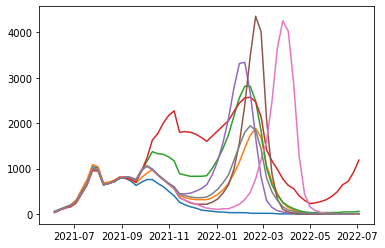

In [65]:
# visual check
plt.clf()
for name,y in ts.items():
    plt.plot(dates, y)
plt.show()

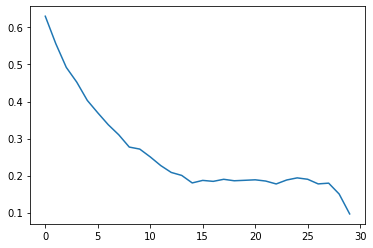

In [66]:
# set up kernel
kernel = [0.63038375, 0.5563235, 0.49222496, 0.45222776, 0.40307487, 0.36944806,
 0.33724373, 0.3100481,  0.27688403, 0.27142026, 0.25031462, 0.22687892,
 0.20832974, 0.20026684, 0.17997222, 0.18681425, 0.18419819, 0.18980143,
 0.18582822, 0.18707532, 0.18841658, 0.18506692, 0.17721939, 0.18791786,
 0.19362596, 0.18988383, 0.17735860,  0.17936534, 0.14999304, 0.0962469]
plt.clf()
plt.plot(range(30), kernel)
plt.show()

In [67]:
# convolve
hs = {}
hs_dates = dates[len(kernel):]
nans = np.empty((len(kernel)-1))
nans[:] = np.nan
for name,y in ts.items():
    hs[name] = np.convolve(y, kernel, mode="valid")
    hs[name] = np.concatenate([nans, hs[name]])

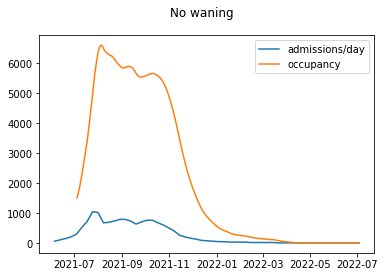

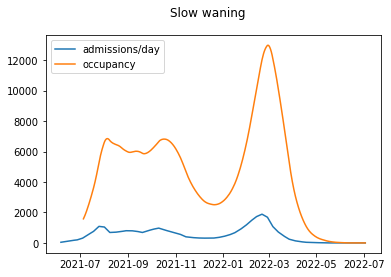

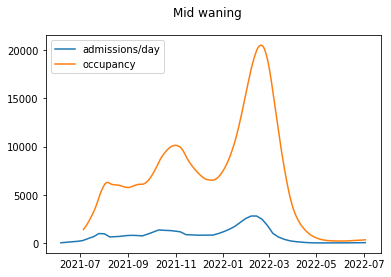

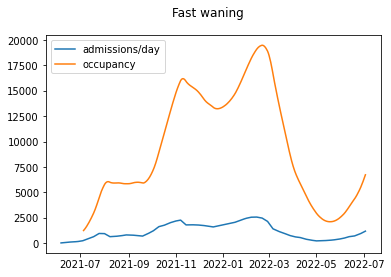

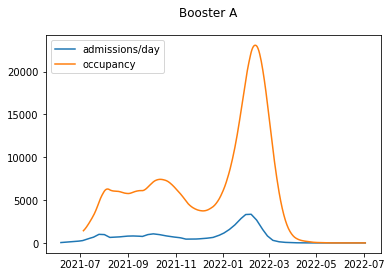

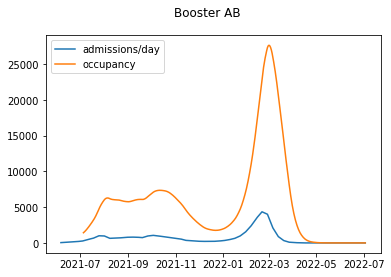

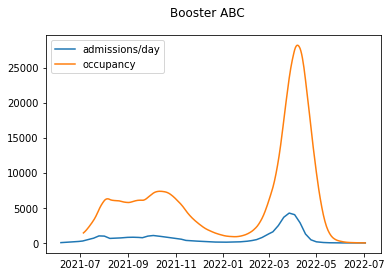

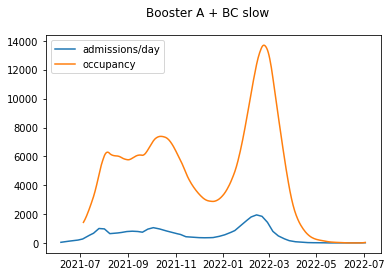

In [68]:
# visual check
for name,y in ts.items():
    plt.clf()
    plt.suptitle(name)
    plt.plot(dates, ts[name], label="admissions/day")
    plt.plot(dates, hs[name], label="occupancy")
    plt.legend()
    plt.show()

In [80]:
# write to disk
prep = []
prep.append([None] + list(dates))
for name in hs.keys():
    prep.append([name + " - admission"] + list(ts[name]))
    prep.append([name + " - occupancy"] + list(hs[name]))

with open('out_hs.csv', 'w') as f:     
    write = csv.writer(f) 
    write.writerows(prep)